# Cleaning

Removing rows not including month and year data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from scipy.stats import chi2_contingency

In [2]:
df = pd.read_excel('data_cleaned.xlsx')
mask = (
  df['year_start'].notna() &
  (df['year_start'] != 0) &
  df['month_start'].notna() &
  (df['month_start'] != 0)
)

df_filtered = df[mask].copy()
df_filtered = df_filtered[['identifier', 'year_start', 'month_start', 'day_start', 'ce_or_bce']]

# Analysis

We test the first hypothesis by first aggregating the number of receipts from each month to examine the distribution of poll tax payments throughout the year. We then perform a Chi-square goodness-of-fit test. The null hypothesis states that the receipts are uniformly distributed across the months of the year, implying that the poll tax was not paid during any specific period. The alternative hypothesis is that the receipts are not uniformly distributed but instead cluster around certain periods.

We set the alpha level for rejecting the null hypothesis at 0.05.

To begin, we count the number of receipts in each month and visualize the distribution using a bar chart.

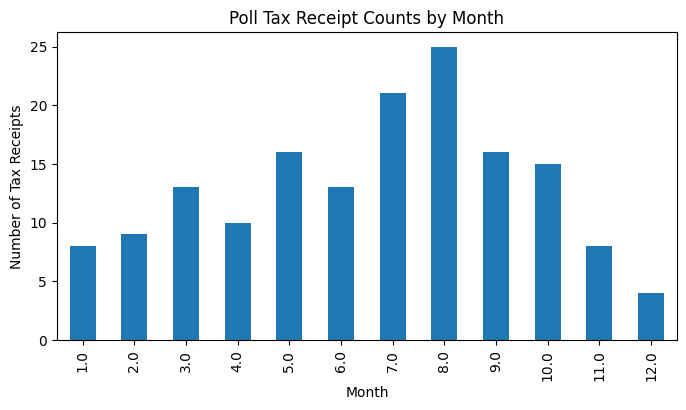

In [4]:
monthly_counts = df_filtered['month_start'].value_counts().sort_index()
plt.figure(figsize=(8, 4))
monthly_counts.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Number of Tax Receipts')
plt.title('Poll Tax Receipt Counts by Month')
plt.show()

August clearly has the most receipts.

In [5]:
total_receipts = monthly_counts.sum()
expected_freq = [total_receipts / 12] * 12
print("Under null hypothesis we expext: ", expected_freq[0].round(), " receipts across all months")
observed_freq = [monthly_counts.get(month, 0) for month in range(1, 13)]
chi2_stat, p_value = chisquare(f_obs=observed_freq, f_exp=expected_freq)
print("Chi-square:", chi2_stat)
print("P-value:", p_value)

Under null hypothesis we expext:  13.0  receipts across all months
Chi-square: 29.291139240506332
P-value: 0.002045339459068769


We obtain a p-value of approximately 0.002, which is below the significance level of 0.05, and therefore we reject the null hypothesis. This provides strong evidence against the idea that poll tax payments were made randomly throughout the year.

Having established that the tax was likely paid during specific periods, we next test whether it was concentrated in the fall months—September, October, and November (months 9, 10, and 11)—as proposed in our initial hypothesis. Our null hypothesis is that 25% of all receipts fall within the fall months and 75% within the non-fall months, assuming a uniform distribution. The alternative hypothesis is that a significantly higher proportion of receipts are concentrated in the fall, suggesting that this was the primary period for poll tax payment.

In [6]:
df_filtered['is_fall'] = df_filtered['month_start'].isin([9, 10, 11])
fall_count = df_filtered['is_fall'].sum()
non_fall_count = len(df_filtered) - fall_count
observed = [fall_count, non_fall_count]
total_receipts = len(df_filtered)
expected = [total_receipts * 0.25, total_receipts * 0.75]
chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)
print("Chi-square statistic:", chi2_stat)
print("P-value:", p_value)

Chi-square statistic: 0.008438818565400843
P-value: 0.9268068551245274


The p-value is very high—well above our alpha level of 0.05—so we fail to reject the null hypothesis. In fact, the high P-value suggests that the proportion of receipts in the fall months is almost exactly what we would expect under a uniform distribution (25% in fall, 75% in non-fall months). Therefore, there is no evidence to suggest that the poll tax was paid specifically during the fall months.

We perform the same test on July, August and September.

In [7]:
df_filtered['jas'] = df_filtered['month_start'].isin([7, 8, 9])
jas_count = df_filtered['jas'].sum()
non_jas_count = len(df_filtered) - jas_count
observed = [jas_count, non_jas_count]
total_receipts = len(df_filtered)
expected = [total_receipts * 0.25, total_receipts * 0.75]
chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)
print("Chi-square statistic:", chi2_stat)
print("P-value:", p_value)

Chi-square statistic: 17.088607594936708
P-value: 3.5675668122074904e-05


Given a p-value well below 0.05, we reject the null hypothesis. There is strong evidence suggesting that the poll tax was paid primarily during late summer and early fall—specifically in July, August, and September.

Next, we test the second hypothesis. We divide the data into 25-year intervals and perform the same Chi-square test, where the null hypothesis is that the distribution of poll tax payments across the months does not differ by period. The alternative hypothesis is that the distribution does differ over time. We use the same siginificance level of 0.05.

In [8]:
def label_subperiod(row):
    year = row['year_start']
    if year >= 1 and year <= 50:
        return "1 CE - 50 CE"
    elif year >= 51 and year <= 100:
        return "51 CE - 100 CE"
    elif year >= 101 and year <= 150:
        return "101 CE - 150 CE"
    elif year >= 151 and year <= 200:
        return "151 CE - 200 CE"
    else:
        return np.nan

df_filtered['sub_period'] = df_filtered.apply(label_subperiod, axis=1)
df_sub = df_filtered.dropna(subset=['sub_period'])
crosstab = pd.crosstab(df_sub['sub_period'], df_sub['month_start'])
chi2_stat, p_value, dof, expected = chi2_contingency(crosstab)
print("Chi-square statistic:", chi2_stat)
print("P-value:", p_value)

Chi-square statistic: 35.77867633592461
P-value: 0.33925518176804564


The p-value is above our alpha level of 0.05, which means we fail to reject the null hypothesis. Notably, this does not prove that the timing of tax payments remained exactly the same throughout the period. However, a p-value of 0.34 indicates that there is no strong statistical evidence to suggest a significant change. Therefore, we conclude that the timing of poll tax payments (i.e., the month in which they were paid) remained relatively consistent from 50 BCE to 250 CE.